##Collect the stock price for Tesla (NASDAQ: TSLA) for the past 30 days.

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import math
from scipy.optimize import minimize
from mpl_toolkits import mplot3d
from matplotlib import cm
from sklearn.metrics import mean_squared_error
from matplotlib import patheffects
import numpy.linalg as la
import pandas_datareader
import datetime
import pandas_datareader.data as web
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr
import yfinance as yfin

##Plot the data (date vs. stock price)

In [ ]:
yfin.pdr_override()

df = pdr.get_data_yahoo('TSLA', start='2023-3-21', end='2023-4-22')

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-21,188.279999,198.000000,188.039993,197.580002,197.580002,153391400
2023-03-22,199.300003,200.660004,190.949997,191.149994,191.149994,150376400
2023-03-23,195.259995,199.309998,188.649994,192.220001,192.220001,144193900
2023-03-24,191.649994,192.360001,187.149994,190.410004,190.410004,116531600
2023-03-27,194.419998,197.389999,189.940002,191.809998,191.809998,120851600
2023-03-28,192.000000,192.350006,185.429993,189.190002,189.190002,98654600
2023-03-29,193.130005,195.289993,189.440002,193.880005,193.880005,123660000
2023-03-30,195.580002,197.330002,194.419998,195.279999,195.279999,110252200
2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007,169638500


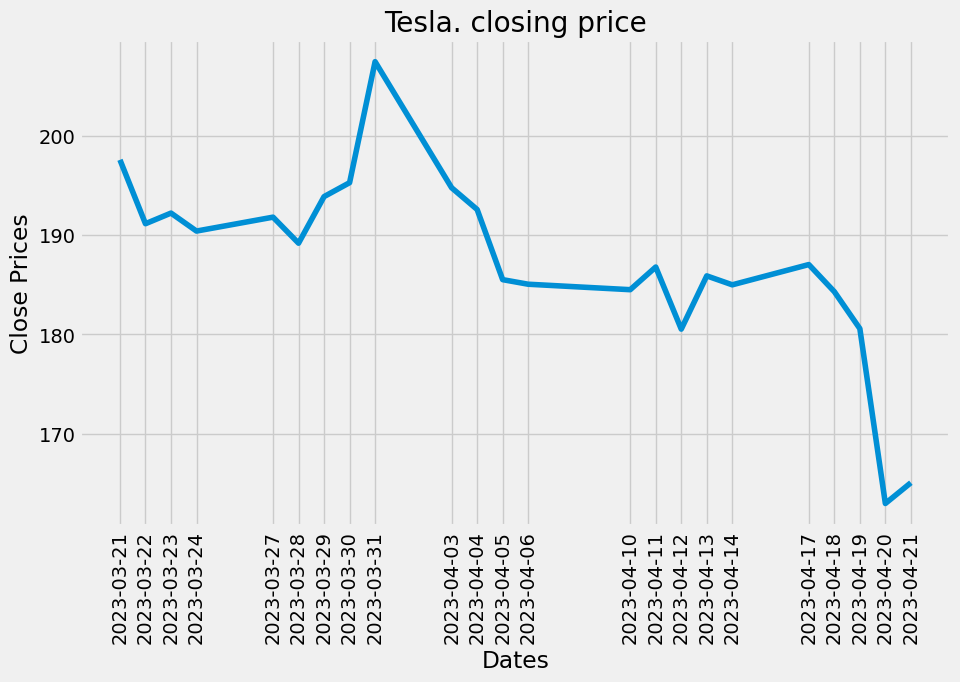

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Tesla. closing price')
plt.xticks(df.index, rotation=90)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 2023-03-21 to 2023-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23 non-null     float64
 1   High       23 non-null     float64
 2   Low        23 non-null     float64
 3   Close      23 non-null     float64
 4   Adj Close  23 non-null     float64
 5   Volume     23 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 1.3 KB


##Implement the stochastic gradient descent algorithm to fit a linear regression model for this data set.

In [ ]:
df.drop(["Adj Close"], axis =1, inplace=True)
df.drop(['High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)
df

,Close
Date,
2023-03-21,197.580002
2023-03-22,191.149994
2023-03-23,192.220001
2023-03-24,190.410004
2023-03-27,191.809998
2023-03-28,189.190002
2023-03-29,193.880005
2023-03-30,195.279999
2023-03-31,207.460007


In [ ]:
df = df.sort_index(ascending=True)
df['date'] = df.index.day
df['month'] = df.index.month

In [ ]:
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
X_train = train[['date','month']]
X_test = test[['date','month']]
y_train = train['Close']
y_test = test['Close']
X = df[['date','month']]
y = df['Close']

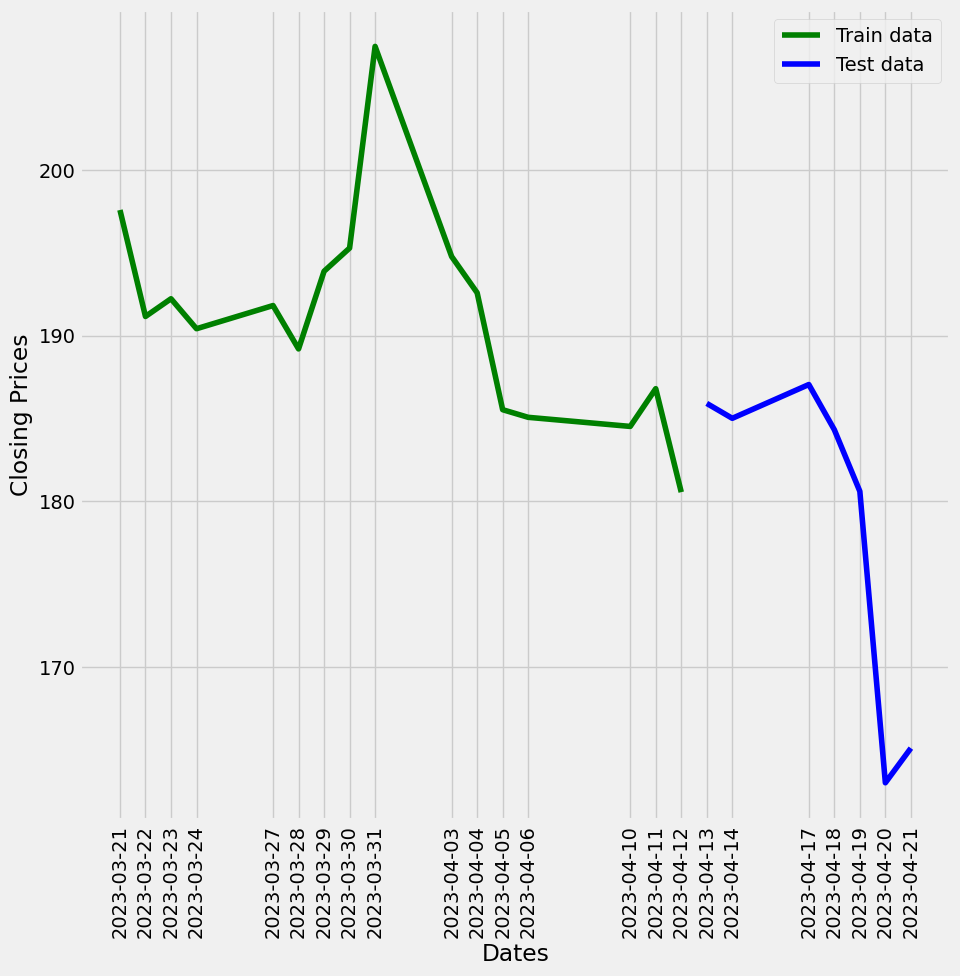

In [ ]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.xticks(df.index, rotation=90)
plt.legend()
plt.show()

In [ ]:
reg = make_pipeline(StandardScaler(),SGDRegressor(max_iter=500,tol=1e-3,validation_fraction=0.1,shuffle=False,verbose=2))
reg.fit(X,y)

-- Epoch 1
Norm: 4.20, NNZs: 2, Bias: 23.754393, T: 23, Avg. loss: 15550.693671
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 4.62, NNZs: 2, Bias: 38.670789, T: 46, Avg. loss: 12342.912075
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 4.82, NNZs: 2, Bias: 50.635413, T: 69, Avg. loss: 10306.494279
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 4.97, NNZs: 2, Bias: 60.776499, T: 92, Avg. loss: 8771.109438
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 5.10, NNZs: 2, Bias: 69.611772, T: 115, Avg. loss: 7553.000046
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.23, NNZs: 2, Bias: 77.440882, T: 138, Avg. loss: 6559.152513
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 5.35, NNZs: 2, Bias: 84.459705, T: 161, Avg. loss: 5733.232194
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.47, NNZs: 2, Bias: 90.806385, T: 184, Avg. loss: 5037.704556
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 5.58, NNZs: 2, Bias: 96.583545, T: 207, Avg. loss: 4446.011183
T

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(max_iter=500, shuffle=False, verbose=2))])

In [ ]:
y_pred=reg.predict(X)
mean_squared_error(y, y_pred)

40.26704099960676

##Plot the raw data and your linear regression model together for visual comparison.

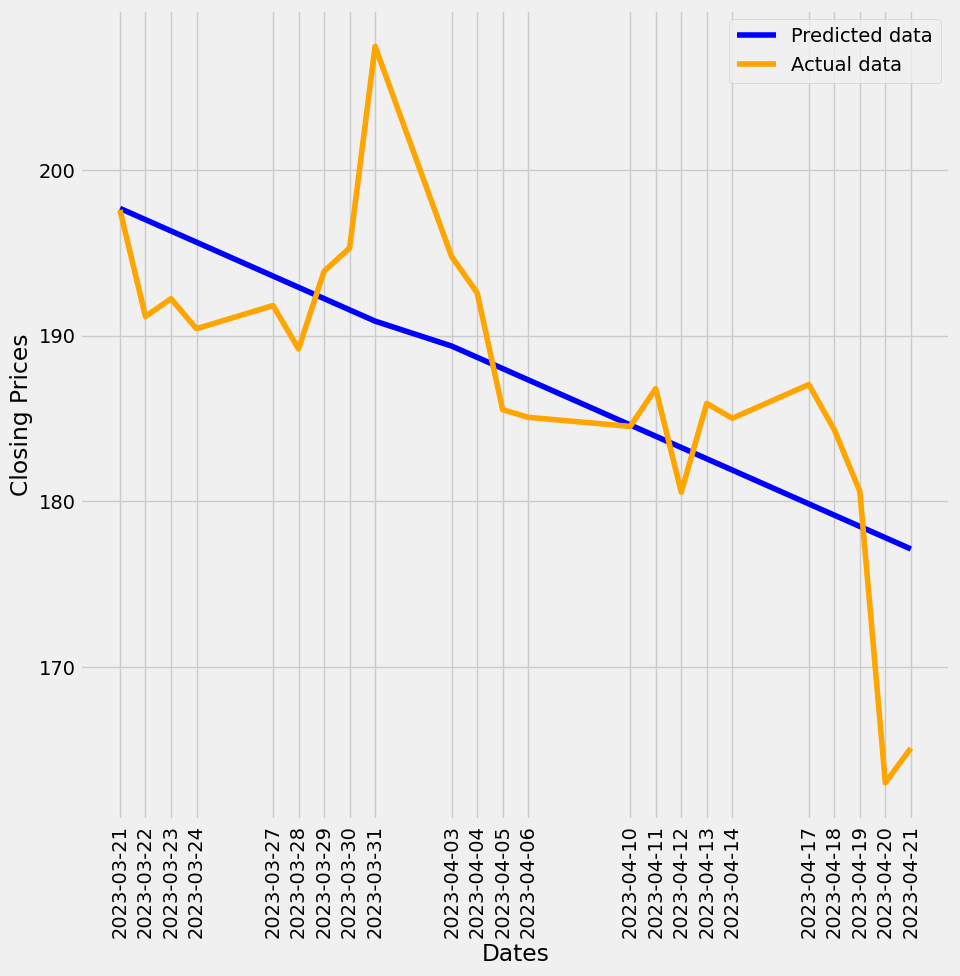

In [ ]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y.index,y_pred, 'blue', label='Predicted data')
plt.plot(y.index,y, 'orange', label='Actual data')
plt.xticks(df.index, rotation=90)
plt.legend()
plt.show()

##What does your model predict for Tesla’s stock price for the next three months into the future?

In [ ]:
add_dates = [df.index[-1] +pd.tseries.offsets.BusinessDay(n = x) for x in range(0,66)]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
future_dates['date'] = future_dates.index.day
future_dates['month'] = future_dates.index.month

In [ ]:
fdf = df.append(future_dates)
fdf.describe()

,Close,date,month
count,23.000000,88.000000,88.000000
mean,187.376521,16.261364,5.170455
std,9.494383,8.764472,1.243111
min,162.990005,1.000000,3.000000
25%,184.754997,9.000000,4.000000
50%,187.039993,17.000000,5.000000
75%,192.400002,23.250000,6.000000
max,207.460007,31.000000,7.000000


In [ ]:
X_new = fdf[future_dates.index[0]:].drop(['Close'],axis=1)
X_new

,date,month
2023-04-24,24,4
2023-04-25,25,4
2023-04-26,26,4
2023-04-27,27,4
2023-04-28,28,4
...,...,...
2023-07-17,17,7
2023-07-18,18,7
2023-07-19,19,7
2023-07-20,20,7


In [ ]:
y_pred=reg.predict(X_new)
y_pred

array([175.06658728, 174.38576058, 173.70493388, 173.02410718,
       172.34328048, 170.15823644, 169.47740974, 168.79658304,
       168.11575634, 167.43492964, 165.39244954, 164.71162284,
       164.03079614, 163.34996944, 162.66914274, 160.62666264,
       159.94583594, 159.26500924, 158.58418254, 157.90335584,
       155.86087574, 155.18004904, 154.49922234, 153.81839564,
       153.13756894, 151.09508884, 150.41426214, 149.73343544,
       149.5908715 , 148.9100448 , 146.8675647 , 146.186738  ,
       145.5059113 , 144.8250846 , 144.1442579 , 142.1017778 ,
       141.4209511 , 140.7401244 , 140.0592977 , 139.378471  ,
       137.3359909 , 136.6551642 , 135.9743375 , 135.2935108 ,
       134.6126841 , 132.570204  , 131.8893773 , 131.2085506 ,
       130.5277239 , 129.8468972 , 127.66185316, 126.98102646,
       126.30019976, 125.61937306, 124.93854636, 122.89606626,
       122.21523956, 121.53441286, 120.85358616, 120.17275946,
       118.13027936, 117.44945266, 116.76862596, 116.08

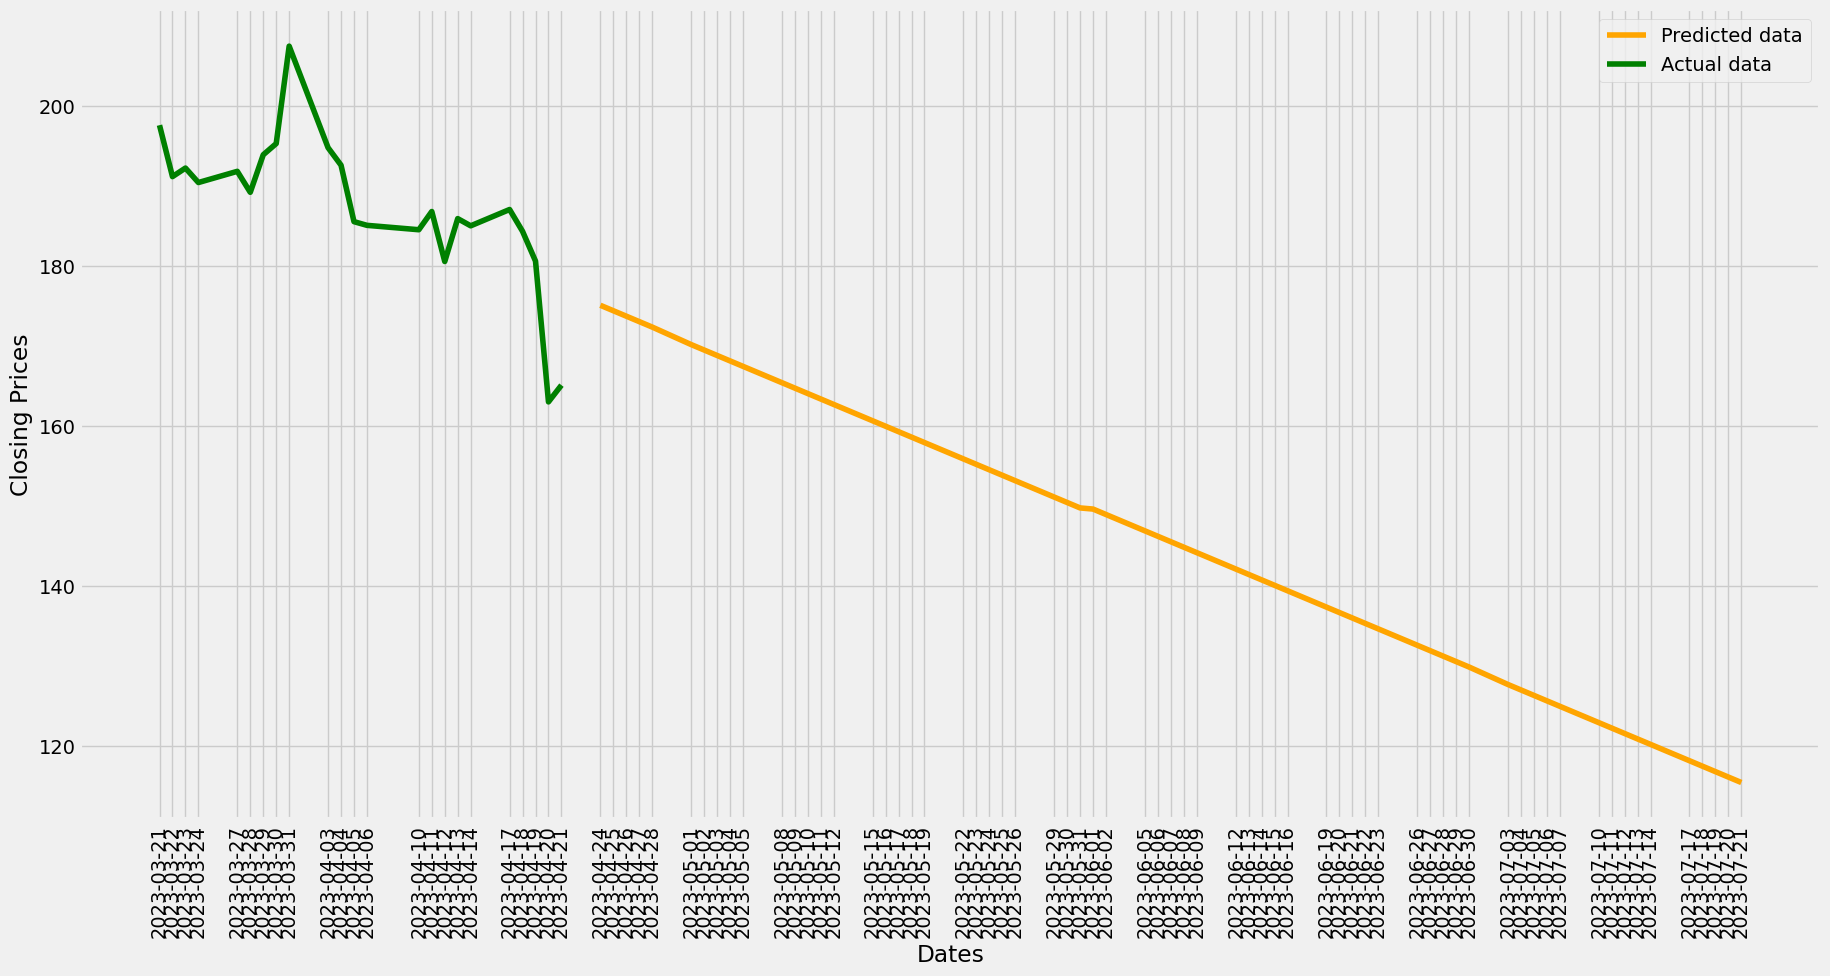

In [ ]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(X_new.index,y_pred, 'orange', label='Predicted data')
plt.plot(y.index,y, 'green', label='Actual data')
plt.xticks(fdf.index, rotation=90)
plt.legend()
plt.show()